# GAIT declaration

Github Copilot was used via an extension on VScode to write comments for all functions and suggest autocomplete options for cells.

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV
)
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score, 
    average_precision_score, precision_recall_curve, auc, f1_score, 
    matthews_corrcoef, roc_curve, RocCurveDisplay
)

In [73]:
test = np.loadtxt('Xtest.csv', delimiter=' ')

In [74]:
print(test)

[[ 0.  0.  0. ...  0.  0. 14.]
 [ 7.  0.  0. ... 20. 40. 35.]
 [17. 56.  0. ... 38.  0.  0.]
 ...
 [ 0. 83.  0. ...  0.  0.  0.]
 [ 0.  0. 22. ... 22. 50.  0.]
 [ 0.  0.  0. ... 92.  0.  8.]]


In [75]:
xtrain = np.loadtxt('Xtrain.csv', delimiter=' ')

In [76]:
ytrain = np.loadtxt('Ytrain.csv', delimiter=' ')

## Question No. 1: Exploring Data  

### 1ia) Dataset Overview  

- **Training Dataset**  
  - The dataset contains 3,000 images, each represented as a 784-dimensional vector.  
  - Each image is labeled as either 1 (positive) or -1 (negative), with no missing labels.  
  - **Class Distribution:**  
    - **Positive Class (1):** 614 examples  
    - **Negative Class (-1):** 2,386 examples  

- **Test Dataset**  
  - The exact class sizes of the test set cannot be confirmed since test data is unlabelled. 
  - However, clustering techniques may help indicate potential class distributions in the test set.



In [9]:
print("Vector size: " + str(ytrain.shape[0]))
print("Class size of 1: " + str(np.count_nonzero(ytrain==1)))
print("Class size of -1: " + str(np.count_nonzero(ytrain==-1)))

Vector size: 3000
Class size of 1: 614
Class size of -1: 2386


#### 1ib) 

The given training dataset has a class imbalance, with significantly fewer positive examples (614) compared to negative examples (2,386). This could introduce some issues in the machine learning solution:  

There is potential for bias towards the class with the most instances as Machine learning models tend to favor the majority class during training. This means the model may predict negative labels far more frequently, reducing its ability to correctly classify positive examples. Due to the limited number of positive examples, the model may not learn sufficient decision boundaries to accurately classify these examples.  

Standard evaluation metrics like accuracy will be misleading in imbalanced datasets. For example, a naive model that always predicts the majority class would achieve a high accuracy but have poor performance for the minority class. Other metrics might have a better representations.

### Visual Data Exploration

#### 1iia)
- **Class Context:**  
  - The dataset groups images into two distinct classes:  
    - **Positive Class:** Includes images of boots and accessories 
    - **Negative Class:** Includes images of trainers and clothing 
  - All the images are oriented upright and contain no noise, surrounded by a border of black pixels.


<function matplotlib.pyplot.show(close=None, block=None)>

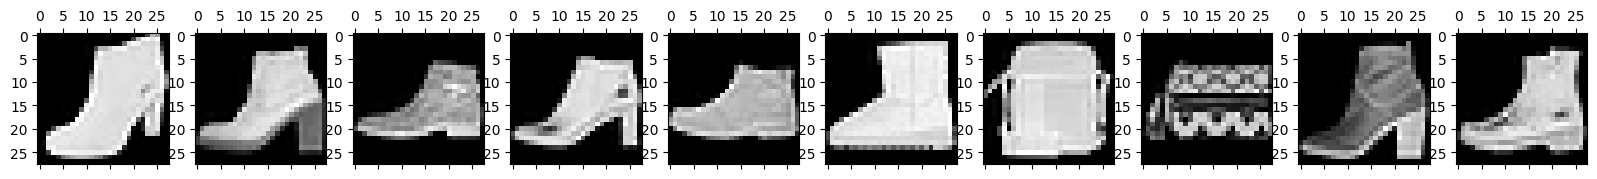

In [21]:
positive = np.where(ytrain ==1)[0]

random = (np.random.choice(positive, size=10, replace=False))

plt.figure(figsize=(20,200))
for i, idx in enumerate(random):
    image = xtrain[idx].reshape(28,28)

    plt.subplot(30,10, i+1)
    plt.matshow(image, cmap = 'gray', fignum = False)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

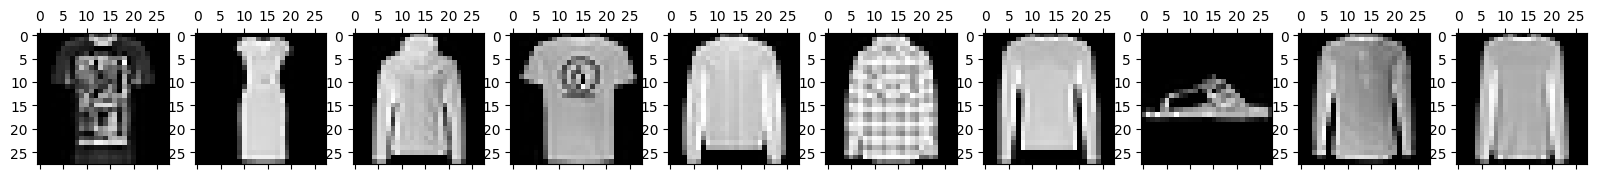

In [22]:
negative = np.where(ytrain ==-1)[0]

random1 = (np.random.choice(negative, size=10, replace=False))

plt.figure(figsize=(20,200))
for i, idx in enumerate(random1):
    image = xtrain[idx].reshape(28,28)

    plt.subplot(30,10, i+1)
    plt.matshow(image, cmap = 'gray', fignum = False)

plt.show


#### 1iib)

- **Noise and Graininess:**  
  - The images in the test set are grainy, introducing visual artifacts that can interfere with feature extraction.  

- **Rotation Variations:**  
  - Each image having differently rotated objects makes it challenging for the classifier to detect patterns that were learned from the one orientation available in the training data.  

- **Scale and Size Variability:**  
  - Objects look like they appear at different scales, which could affect the model's ability to identify key features.  


#### Impact on Model Generalization  
- These factors collectively increase the difficulty for the classifier to generalise from the training data to the unseen test images.  

<function matplotlib.pyplot.show(close=None, block=None)>

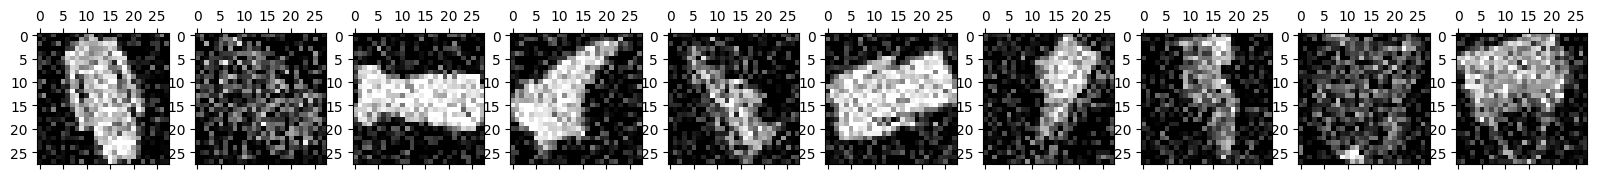

In [23]:
random = np.random.choice(test.shape[0], size=10, replace=False)

plt.figure(figsize=(20,200))
for i, idx in enumerate(random):
    image = test[idx].reshape(28,28)

    plt.subplot(1,10, i+1)
    plt.matshow(image, cmap = 'gray', fignum = False)

plt.show

### Choosing the Right Metric

#### 1iii)

#### Accuracy
-  Proportion of correctly predicted instances over the total number of instances.  
- **Formula:** $$(TP + TN) / (TP + TN + FP + FN)$$  
- Accuracy is easy to understand but is assumes that the dataset is balanced. If the data is imbalanced, the accuracy may appear to be really high becuase the model simply predicts the majority class most of the time, while the correctly identified items in the minority class may be much lower. In this imbalanced dataset, where identifying both classes is equally important, this is not ideal.

####  AUC-ROC (Area Under the Receiver Operating Characteristic Curve)
-  The probability with which a randomly-chosen positive example is ranked more highly than a randomly-chosen negative example by a classifier. A higher AUC-ROC indicates that the model effectively separates positive and negative classes. Again imbalances in the dataset can cause the model to be overly optimistic, especially as the positive class is rare in this dataset.  

####  AUC-PR (Area Under the Precision-Recall Curve)
-  Measures the trade-off between precision and recall. It measures the trade-off between precision and recall. This means it is better than AUC-ROC in this dataset where there is a lot more negative instances than positive.

#### F1-Score 
- Harmonic mean of precision and recall.  
- **Formula:** $$ F1 = 2 \times \frac{{\text{Precision} \times \text{Recall}}}{{\text{Precision} + \text{Recall}}} $$  
- It considers both false positives and false negatives in cases where both classes are important with no priority.

####  Matthews Correlation Coefficient (MCC) 
-  A balanced metric that takes into account all four confusion matrix components (TP, TN, FP, FN).  
- **Formula:**  
  $$
  MCC = \frac{{(TP \times TN) - (FP \times FN)}}{{\sqrt{{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}}}
  $$
-  Imbalanced datasets, as it provides a robust and balanced evaluation regardless of class distribution.  

####  Mean Squared Error (MSE) 
-  Measures the average squared difference between the predicted and actual values. It is typically used for regression tasks rather than classification, especially since this is a binary classification problem, it is largely inappropriate.  

-----------------------------

### Recommended Metric for This Task
Considering the class imbalance and the need for balanced evaluation between false positives and false negatives:
-  Matthews Correlation Coefficient (MCC) accounts for both false positives and false negatives and is robust to imbalanced datasets. However, additional metrics can only provide further insight into the performance of the models so this should be paired with use of AUC-PR, as it provides meaningful insights into performance in imbalanced settings.  

####  1iv . Benchmarking a Random Classifier

A random classifier would have an accuracy of about 50% for both training and test datasets, as there are only two possible classes. There will be some fluctuation around this point due to random chance, but will always be close to 50%. We can prove this on the training data in the next section. 

We cannot prove this code-wise on the test data, as it is unlabelled and therefore we cannot confirm an exact accuracy, even if attempting to classify each image ourselves.


In [51]:
random_values = np.random.uniform(-1, 1, size=len(ytrain))
random_prediction_scores = np.where(random_values > 0, 1, -1)
random_accuracy_train = np.mean(random_prediction_scores == ytrain)
print(f"Random classifier accuracy on training set: {random_accuracy_train:.4f}")

Random classifier accuracy on training set: 0.5050


#### 1v. Understanding AUC Metrics for Random Classifier
The AUC-ROC will also average at around 0.5 chance, which is the same as before. This is because the ROC curve will lie close to the diagonal line where TP is equal to FP.

However, the AUC-PR will be  slightly lower, and may depend on the percentage of the postive samples present in the data. In this case the data has about 20% positive data and theoretically a random classifier will show a similar representation of correctly identified positive data. This shows that a random classifier has no real predictive power and is influenced by the percentages of positive and negative classes.



In [52]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, average_precision_score

roc_auc = roc_auc_score(ytrain, random_prediction_scores)

pr_auc = average_precision_score(ytrain, random_prediction_scores)

print(f"AUC-ROC for random classifier: {roc_auc:.4f}")
print(f"AUC-PR for random classifier: {pr_auc:.4f}")


AUC-ROC for random classifier: 0.5062
AUC-PR for random classifier: 0.2067


## Question No. 2: Nearest Neighbour Classifier  

### i)

In [10]:
k_folds = 5
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

accuracies = []
balanced_accuracies = []
auc_roc_scores = []
auc_pr_scores = []
f1_scores = []
mcc_scores = []

fpr_one_fold = None
tpr_one_fold = None
precision_one_fold = None
recall_one_fold = None

for train_index, test_index in kf.split(xtrain, ytrain):
    X_train, X_test = xtrain[train_index], xtrain[test_index]
    Y_train, Y_test = ytrain[train_index], ytrain[test_index]
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, Y_train)
    
    y_pred = knn.predict(X_test)
    y_proba = knn.predict_proba(X_test)[:, 1] 

    accuracies.append(accuracy_score(Y_test, y_pred))
    balanced_accuracies.append(balanced_accuracy_score(Y_test, y_pred))
    auc_roc_scores.append(roc_auc_score(Y_test, y_proba))
    
    precision, recall, _ = precision_recall_curve(Y_test, y_proba)
    auc_pr_scores.append(auc(recall, precision))
    
    f1_scores.append(f1_score(Y_test, y_pred))
    mcc_scores.append(matthews_corrcoef(Y_test, y_pred))

    if fpr_one_fold is None:
        fpr_one_fold, tpr_one_fold, _ = roc_curve(Y_test, y_proba)
        precision_one_fold, recall_one_fold, _ = precision_recall_curve(Y_test, y_proba)

metrics = {
    'Accuracy': [np.mean(accuracies), np.std(accuracies)],
    'Balanced Accuracy': [np.mean(balanced_accuracies), np.std(balanced_accuracies)],
    'AUC-ROC': [np.mean(auc_roc_scores), np.std(auc_roc_scores)],
    'AUC-PR': [np.mean(auc_pr_scores), np.std(auc_pr_scores)],
    'F1 Score': [np.mean(f1_scores), np.std(f1_scores)],
    'MCC': [np.mean(mcc_scores), np.std(mcc_scores)]
}

metrics_df = pd.DataFrame(metrics, index=['Mean', 'Standard Deviation'])
print(metrics_df)

                    Accuracy  Balanced Accuracy   AUC-ROC    AUC-PR  F1 Score  \
Mean                0.965667           0.944563  0.974796  0.962264  0.915558   
Standard Deviation  0.002906           0.006652  0.004005  0.006233  0.006233   

                         MCC  
Mean                0.894403  
Standard Deviation  0.008010  


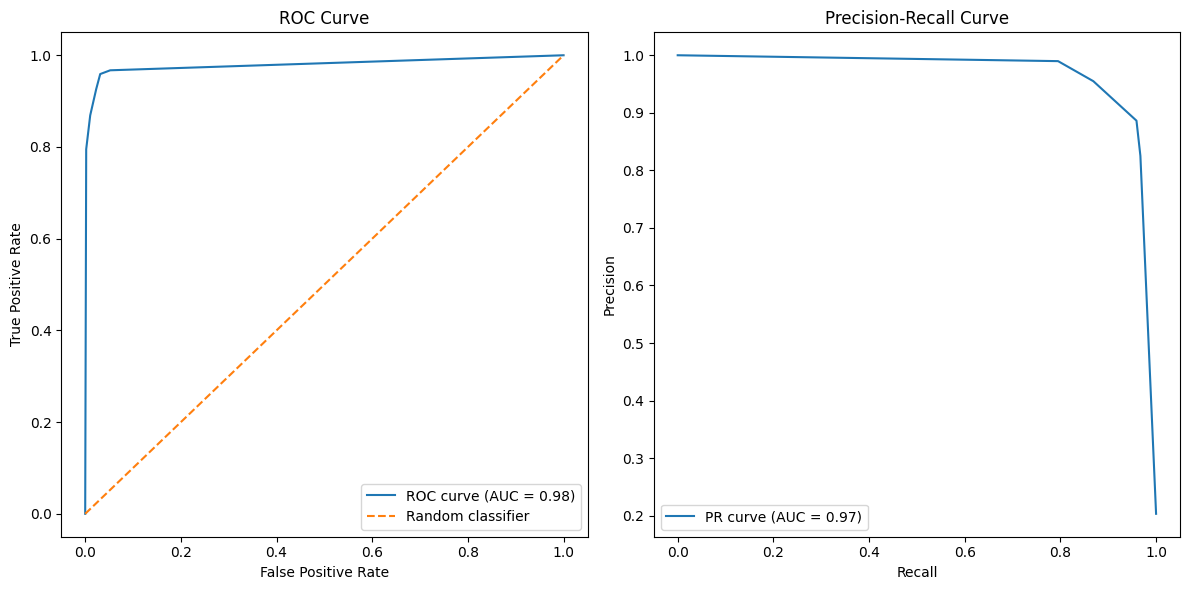

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_one_fold, tpr_one_fold, label='ROC curve (AUC = %0.2f)' % auc_roc_scores[0])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall_one_fold, precision_one_fold, label='PR curve (AUC = %0.2f)' % auc_pr_scores[0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

### ii) 

The ROC curve shows a high AUC of 0.98, which means the model's really good at telling classes apart. The steep rise near the origin means the model hits a high true positive rate while keeping false positives low. The orange dashed line (AUC of 0.5) is the baseline for a random guesser (as discussed in Question 1), and our model's definitely better than that.

The PR curve also looks high with an AUC of 0.97. There's a flat section where precision stays high even at low recall levels, which shows the model's confident in its positive predictions. But when recall gets higher, precision dips so it starts flagging a bunch of false positives, which is very normal especially for imbalanced datasets. 

Because this dataset is imbalanced with mostly negative cases, the top left side of the ROC curve is what we focus on. This area shows that the model provides reliable predictions without a large number of false positive alerts. The closer it is to being a right angled corned, the more True positives there are compared to False positives.

## Question No. 3: Cross-validation of SVM and RFs 

### i)

The best classifier is selected after a variety of tests.

First off, scaling the algorithm is crucial especially when testing SVMs that are sensitive to feature magnitude. To do so, StandardScalar is used initially on the training data only. 

For cross-validation, we use Stratified K-Fold (with five folds) to maintain balanced class distributions and get reliable generalisation estimates. This is done within hyperparameter tuning using the GridSearchCV function to explore different combinations for both SVM (parameters like C, kernel type, degree, and gamma) and Random Forest (like n_estimators, max depth, and split criteria).

To avoid GridSearch being able to see all our data (and therefore to prevent data leakage) and affecting our final AUC-ROC and AUC-PR score, we can perform a train-test split initially, so 80% of the data is used in the cross-validation, and the remaining 20% is used as test data to measure values such as True positives, for the final graphs. This also therefore helps to prevent overfitting and to test the generalisation of the model.

GridSearchCV is also then set to use scoring as AUC-PR to select the best model that maximises the metrics value. The model with the highest AUC-PR will have its parameters returned at the end showing us a good indication of what model and parameters combinations works best together. 

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(xtrain)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_param_grid = {
    'C': [0.1, 1, 10, 100], 
    'kernel': ['linear', 'poly', 'rbf'],  
    'degree': [2, 3, 4, 5, 6], 
    'gamma': ['scale', 'auto'],  
}


rf_param_grid = {
    'n_estimators': [50, 100, 200, 300, 500], 
    'max_depth': [5, 10, 20, 50, 100], 
    'min_samples_split': [2, 5, 10, 20, 50],  
    'min_samples_leaf': [1, 2, 5, 10, 20],  
}

svm = SVC(probability=True)
rf = RandomForestClassifier(random_state=42)

svm_grid_search = GridSearchCV(svm, svm_param_grid, cv=cv, scoring='average_precision', n_jobs=-1)
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=cv, scoring='average_precision', n_jobs=-1)

svm_results = []
rf_results = []

In [9]:
def get_cross_val_metrics(model, X, y, cv):
    balanced_accuracies = [balanced_accuracy_score(y[val_idx], model.fit(X[train_idx], y[train_idx]).predict(X[val_idx]))
                            for train_idx, val_idx in cv.split(X, y)]
    auc_rocs = [roc_auc_score(y[val_idx], model.predict_proba(X[val_idx])[:, 1]) 
                for train_idx, val_idx in cv.split(X, y)]
    auc_prs = [average_precision_score(y[val_idx], model.predict_proba(X[val_idx])[:, 1]) 
               for train_idx, val_idx in cv.split(X, y)]

    return (np.mean(balanced_accuracies), np.std(balanced_accuracies),
            np.mean(auc_rocs), np.std(auc_rocs),
            np.mean(auc_prs), np.std(auc_prs))

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_scaled, ytrain, test_size = 0.2, random_state = 25)

svm_grid_search.fit(X_train, Y_train)
svm_best_model = svm_grid_search.best_estimator_

svm_mean_balanced_accuracy,svm_std_balanced_accuracy, svm_mean_auc_roc,svm_std_auc_roc, svm_mean_auc_pr, svm_std_auc_pr = get_cross_val_metrics(svm_best_model, X_train, Y_train, cv)

svm_results.append({
    'Model': 'SVM',
    'Mean Accuracy': np.mean(svm_grid_search.cv_results_['mean_test_score']),
    'Std Accuracy': np.std(svm_grid_search.cv_results_['mean_test_score']),
    'Mean Balanced Accuracy': svm_mean_balanced_accuracy,
    'Std Balanced Accuracy': svm_std_balanced_accuracy,  
    'Mean AUC-ROC': svm_mean_auc_roc,
    'Std AUC-ROC': svm_std_auc_roc,  
    'Mean AUC-PR': svm_mean_auc_pr,
    'Std AUC-PR': svm_std_auc_pr,  
})

rf_grid_search.fit(X_train, Y_train)
rf_best_model = rf_grid_search.best_estimator_

rf_mean_balanced_accuracy,rf_std_balanced_accuracy, rf_mean_auc_roc,rf_std_auc_roc, rf_mean_auc_pr,rf_std_auc_pr = get_cross_val_metrics(rf_best_model, X_train, Y_train, cv)

rf_results.append({
    'Model': 'Random Forest',
    'Mean Accuracy': np.mean(rf_grid_search.cv_results_['mean_test_score']),
    'Std Accuracy': np.std(rf_grid_search.cv_results_['mean_test_score']),
    'Mean Balanced Accuracy': rf_mean_balanced_accuracy,
    'Std Balanced Accuracy': rf_std_balanced_accuracy,
    'Mean AUC-ROC': rf_mean_auc_roc,
    'Std AUC-ROC': rf_std_auc_roc,
    'Mean AUC-PR': rf_mean_auc_pr,
    'Std AUC-PR': rf_std_auc_pr,
})

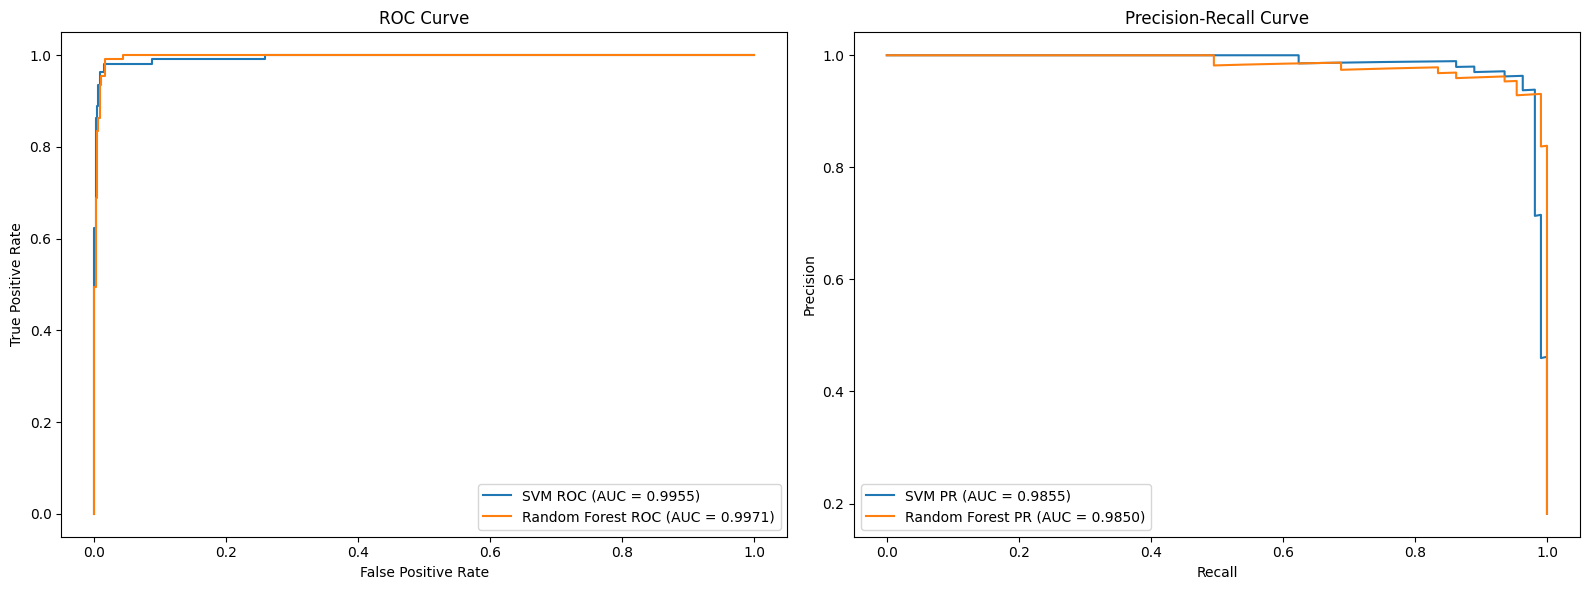

In [12]:
def plot_roc_pr_curves(svm_model, rf_model, X_test, Y_test):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    for model, label, ax in [(svm_model, 'SVM', ax1), (rf_model, 'Random Forest', ax1)]:
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(Y_test, y_pred_prob)
        roc_auc = roc_auc_score(Y_test, y_pred_prob)
        ax.plot(fpr, tpr, label=f'{label} ROC (AUC = {roc_auc:.4f})')

    ax1.set_title('ROC Curve')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend()

    for model, label, ax in [(svm_model, 'SVM', ax2), (rf_model, 'Random Forest', ax2)]:
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
        pr_auc = average_precision_score(Y_test, y_pred_prob)
        ax.plot(recall, precision, label=f'{label} PR (AUC = {pr_auc:.4f})')

    ax2.set_title('Precision-Recall Curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    plt.tight_layout()
    plt.show()

plot_roc_pr_curves(svm_best_model, rf_best_model, X_test, Y_test)


In [13]:
results_df = pd.DataFrame(svm_results + rf_results)
print(results_df)

print(f"\nBest hyperparameters for RF:")
print(rf_grid_search.best_params_)
print(f"\nBest hyperparameters for SVM:")
print(svm_grid_search.best_params_)

           Model  Mean Accuracy  Std Accuracy  Mean Balanced Accuracy  \
0            SVM       0.948011      0.021397                0.951096   
1  Random Forest       0.964114      0.008335                0.943107   

   Std Balanced Accuracy  Mean AUC-ROC  Std AUC-ROC  Mean AUC-PR  Std AUC-PR  
0               0.013138      0.998156     0.003689     0.996526    0.006949  
1               0.023681      0.997651     0.004697     0.996702    0.006596  

Best hyperparameters for RF:
{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Best hyperparameters for SVM:
{'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


#### v)
The AUC-ROC and AUC-PR both indicate high levels of correct classifications. In fact both models perform similarly, but there is a slight advantage in the performanance of the SVM model in the Precision-Recall curve, the metric we are most closely considering. 

## Question No. 4: PCA

### i) 

The outputted graph suggests there are two classes with some overlap, indicating the data is not perfectly seperable. The middle region contains a lot of overlapping points. 

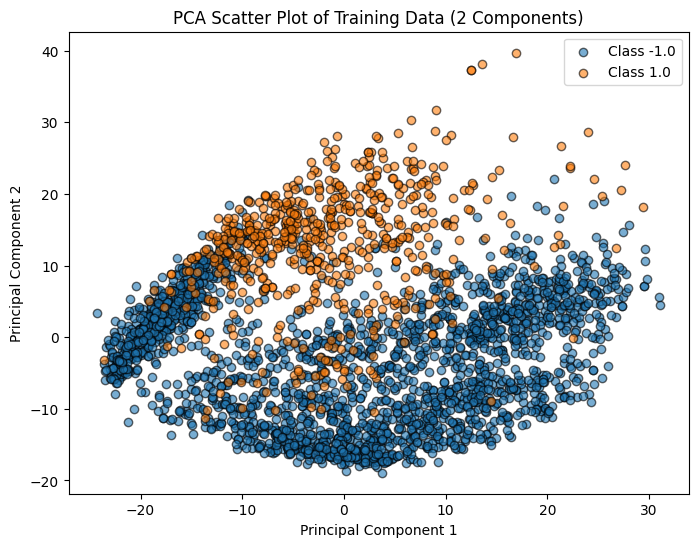

In [20]:
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(test)

pca_2 = PCA(n_components=2)
xtrain_pca_2 = pca_2.fit_transform(xtrain_scaled)
xtest_pca_2 = pca_2.transform(xtest_scaled)

plt.figure(figsize=(8, 6))
for label, colour in zip(np.unique(ytrain), ['blue', 'red']):
    plt.scatter(xtrain_pca_2[ytrain == label, 0], xtrain_pca_2[ytrain == label, 1],
                label=f"Class {label}", alpha=0.6, edgecolor='k')
plt.title("PCA Scatter Plot of Training Data (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

#### 4ii)

The training and test data seems to follow a very similar distribution. This means the test data's primary two components are not drastically different to the training datas pattern. There arent any extreme outliers, although some test values are slightly outside of the bounds of the training data, indicating there should be pretty strong generalisation.

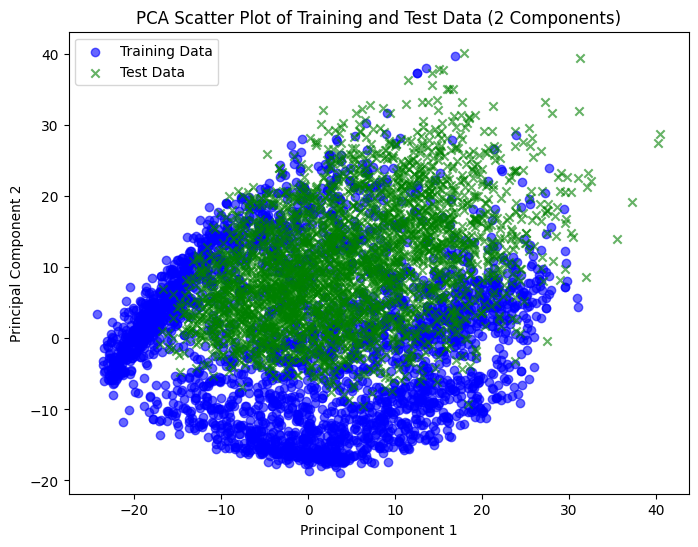

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(xtrain_pca_2[:, 0], xtrain_pca_2[:, 1], c='blue', marker='o', label='Training Data', alpha=0.6)
plt.scatter(xtest_pca_2[:, 0], xtest_pca_2[:, 1], c='green', marker='x', label='Test Data', alpha=0.6)
plt.title("PCA Scatter Plot of Training and Test Data (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

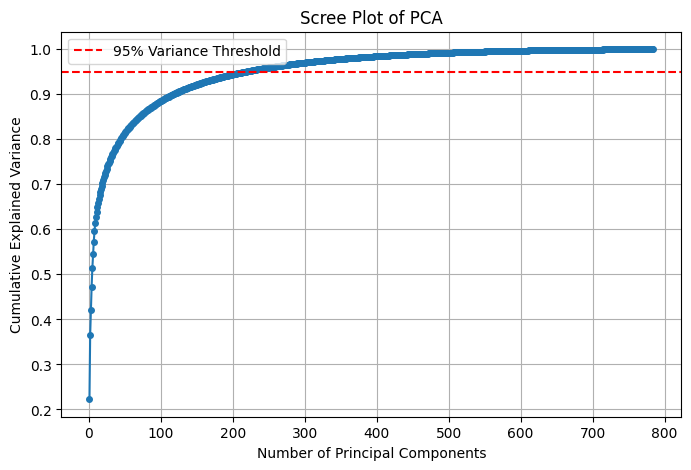

Number of components to explain 95% variance: 217


In [53]:
xtrain_scaled = scaler.fit_transform(xtrain)
pca_full = PCA()
pca_full.fit(xtrain_scaled)
explained_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', markersize=4)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.title("Scree Plot of PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid()
plt.show()

num_components_95_variance = np.argmax(explained_variance_ratio >= 0.95) 
print(f"Number of components to explain 95% variance: {num_components_95_variance}")


In [21]:
#Using SVC() calls on the RBF kernel by default which was found to be the better performing kernel earlier.
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),  
    ('svm', SVC())  
])

param_grid = {
    'pca__n_components': [5, 50, 100, 150, 200, 250], 
    'svm__C': [0.1, 1, 10, 100], 
    'svm__gamma': ['scale', 'auto', 0.1, 1, 10] 
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring="average_precision", n_jobs=-1, verbose=1)
grid_search.fit(xtrain_scaled, ytrain)

print(f"Best cross-validation score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best cross-validation score: 0.9808850360572983
Best parameters: {'pca__n_components': 150, 'svm__C': 10, 'svm__gamma': 'scale'}


## Question No. 5: Optimal Pipeline

The optimal pipeline in this code uses the data from Question 3 to limit classifier models to SVM, as this is aiming to prioritise AUC-PR. This means the ideal kernel found from that question is also assumed to be best here. 

This pipeline follows a very similar route to previous questions, where standard scalar is performed, then component analysis and then the actual model is trained. The crucial difference is that there is some preprocessing applied here to ensure training data is generalised enough to apply to test data. 

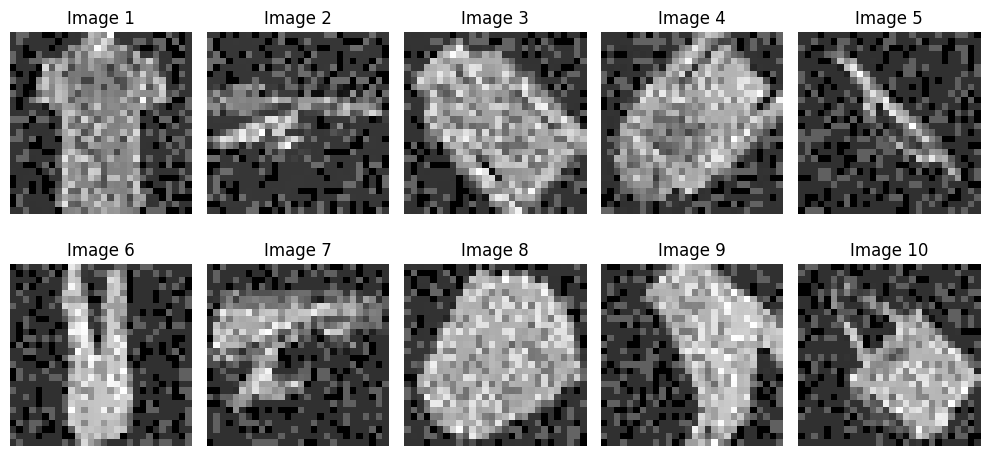

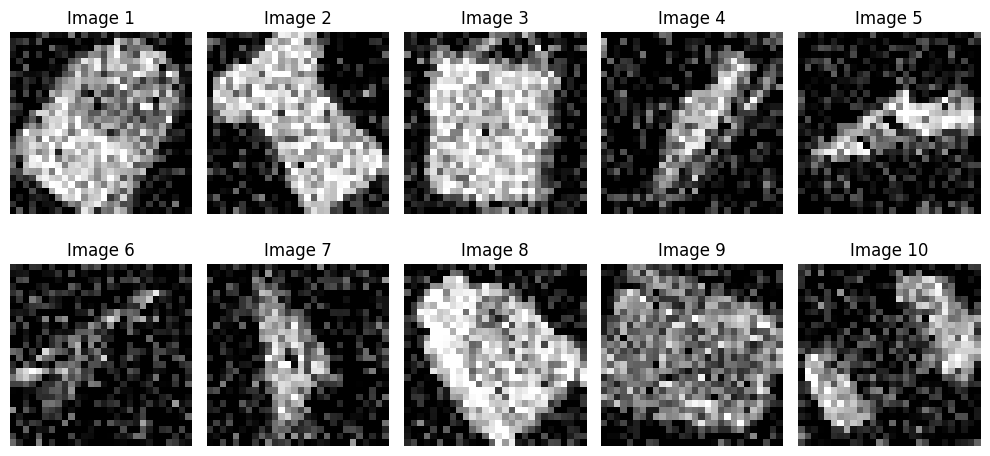

In [171]:
def preprocess(images):
    fixed = []
    for image in images:
        image = image.reshape(28,28)
        image = rotate(image, angle=np.random.choice ([0,45,135,180]), reshape = False)
        image = np.clip(image,5,255)
        image =image + np.random.choice([0,1,2,-75,75], size = image.shape)
        fixed.append(image.flatten())
    return np.array(fixed)
    
xtrain_noisy = preprocess(xtrain)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1) 
    plt.imshow(xtrain_noisy[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    plt.title(f"Image {i+1}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1) 
    plt.imshow(test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    plt.title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [172]:
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain_noisy)

pipeline = Pipeline([
    ('pca', PCA()), 
    ('svm', SVC(kernel='rbf', random_state=42, probability=True)) 
])


param_grid = {
    'pca__n_components': [5, 50, 100, 150, 200, 250], 
    'svm__C': [0.1, 1, 10, 100], 
    'svm__gamma': ['scale', 'auto'],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='average_precision', n_jobs=-1, verbose=1)

grid_search.fit(xtrain_scaled, ytrain)

best_model = grid_search.best_estimator_

xtest_scaled = scaler.transform(xtest)  
xtest_predictions = best_model.predict_proba(xtest_scaled)[:, 1] 

student_id = "u2106063" 
output_file = f"{student_id}.csv"

pd.DataFrame(xtest_predictions, columns=["Prediction"]).to_csv(output_file, index=False, header=False)

print(f"Prediction file saved as {output_file}")

print(f"Best cross-validation score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Prediction file saved as u2106063.csv
Best cross-validation score: 0.934050189463635
Best parameters: {'pca__n_components': 50, 'svm__C': 10, 'svm__gamma': 'scale'}


## Question No. 6: Another classification problem

#### i)

The value of AUC-ROC produced in this graph is 1.0, showing that there are significant differences between the training and test sets. This is because the classifier has performed perfectly without a single overlap in predictions, showing the two classes are completely seperable.

#### ii) 

This experiment doesnt allow us to actually identify the systematic differences between the two data sets, but by visually inspecting the images in both test sets, some clear differences are identified. This was indicated already by the experiment as mentioned above, but visual inspection allowed us to identify what the differences are. In this case, noise and rotations were significantly different features. The experiment produces a trained model that we can then use to reevaluate processed training data. 

In [165]:
ytrain_alt = np.full(xtrain.shape[0], -1)
ytest_alt = np.full(xtest.shape[0], 1)

data_combined = np.vstack((xtrain, xtest))
labels_combined = np.concatenate((ytrain_alt, ytest_alt))

scaler = StandardScaler()
data_combined_scaled = scaler.fit_transform(data_combined)

classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=50,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42
)

skf = StratifiedKFold(n_splits=5)
auc_scores = []

for train_index, test_index in skf.split(data_combined_scaled, labels_combined):
    X_train, X_test = data_combined_scaled[train_index], data_combined_scaled[test_index]
    y_train, y_test = labels_combined[train_index], labels_combined[test_index]

    classifier.fit(X_train, y_train)
    y_proba = classifier.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc_score)

print("\nCross-Validation AUC-ROC Results for Alternate Classification Problem:")
print(f"Mean AUC-ROC: {np.mean(auc_scores):.4f}")
print(f"Standard Deviation of AUC-ROC: {np.std(auc_scores):.4f}")



Cross-Validation AUC-ROC Results for Alternate Classification Problem:
Mean AUC-ROC: 1.0000
Standard Deviation of AUC-ROC: 0.0000


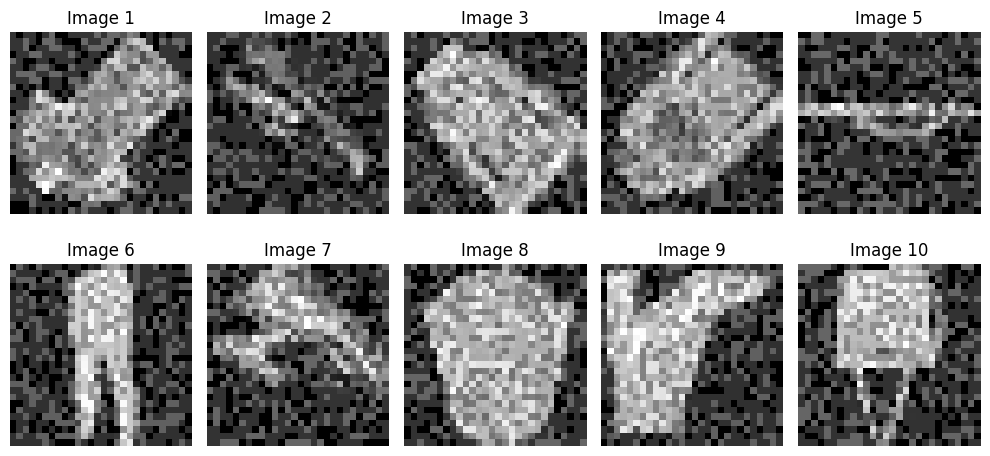

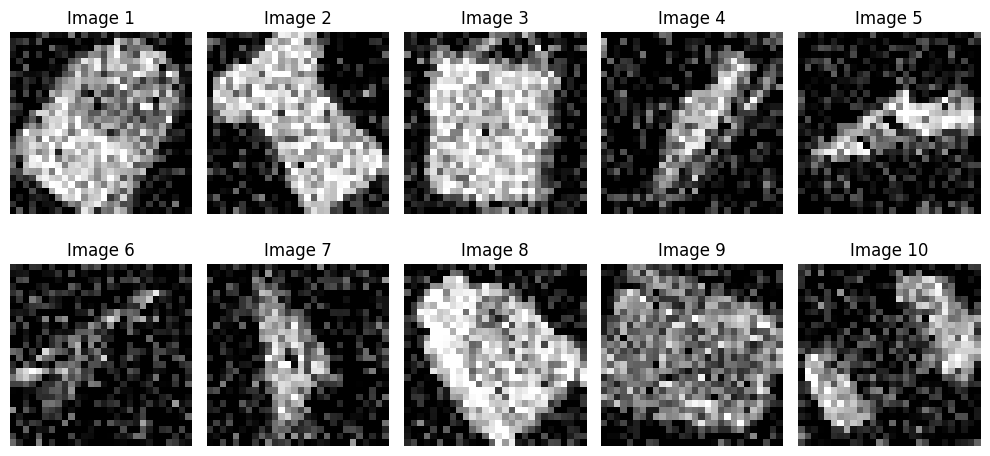

In [167]:
def preprocess(images):
    fixed = []
    for image in images:
        image = image.reshape(28,28)
        image = rotate(image, angle=np.random.choice ([0,45,135,180]), reshape = False)
        image = np.clip(image,5,255)
        image =image + np.random.choice([0,1,2,-75,75], size = image.shape)
        
        fixed.append(image.flatten())
    return np.array(fixed)
    
xtrain_noisy = preprocess(xtrain)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1) 
    plt.imshow(xtrain_noisy[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    plt.title(f"Image {i+1}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1) 
    plt.imshow(test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    plt.title(f"Image {i+1}")

plt.tight_layout()
plt.show()


Performance of Pre-Trained Classifier on Noisy vs. Clean Data:
AUC-ROC Score: 0.5141


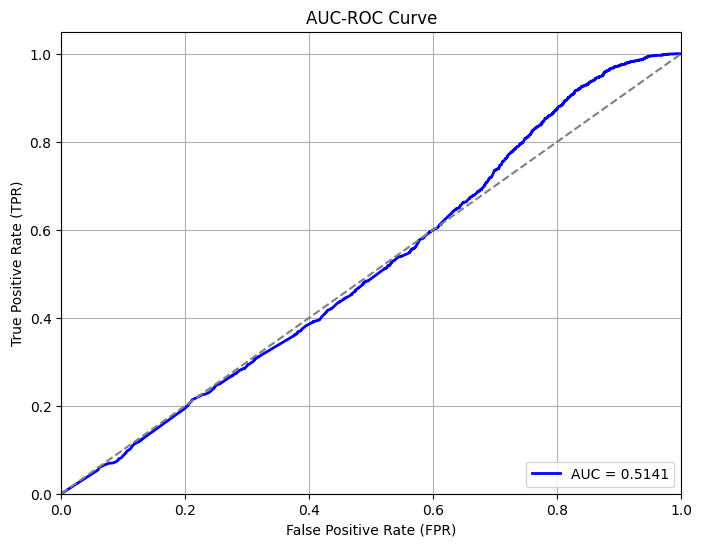

In [168]:
labels_combined = np.concatenate((np.full(xtrain_noisy.shape[0], -1), np.full(xtest.shape[0], 1)))

modified_data_combined = np.vstack((xtrain_noisy, xtest))

modified_data_combined_scaled = scaler.transform(modified_data_combined)

y_proba = classifier.predict_proba(modified_data_combined_scaled)[:, 1]

auc_score = roc_auc_score(labels_combined, y_proba)

fpr, tpr, _ = roc_curve(labels_combined, y_proba)
roc_auc = auc(fpr, tpr)

print("\nPerformance of Pre-Trained Classifier on Noisy vs. Clean Data:")
print(f"AUC-ROC Score: {auc_score:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("AUC-ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

#### 6iii)

After random noise and random rotations are added to the code, the training data somewhat matches the test data and produces an almost random classifier. This is because the differences between the datasets now are negligible creating a relatively even chance of identifying either data set.